# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv

In [3]:
tf.__version__

'2.1.0'

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9092400978246960214
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1012712274252169656
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 882522141039483367
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11423730342463798076
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 12067350185307586954
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_

In [5]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [6]:
# location of *.h5 files
#data_dir = f"{ROOT_DIR}/data"
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [7]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [8]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [9]:
# plot_angles_count(angles_true)

---

## Prepare for training

In [9]:
from sklearn.model_selection import train_test_split
from cryoem.distance_estimation import create_pairs

In [10]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

In [11]:
X_max_px = np.max(X)
X = X/X_max_px
print(f"Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to {X_max_px}")

Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to 15.440114974975586


In [13]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

np.savez("data/5j0n/5j0n_siamese_idx", train_idx, val_idx, test_idx)

In [14]:
# TRAIN: 0.67 * 0.75 = 0.5025 => 2512 imgs => max pairs: 6 311 400
# TEST:  0.33                 => 1650 imgs => max pairs: 2 722 500
# VAL:   0.67*0.25 = 0.1675   =>  837 imgs => max pairs:   700 569

In [15]:
np.save("data/5j0n/test_idx", test_idx)

In [12]:
data = np.load("data/5j0n/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [17]:
# from scipy.spatial.transform import Rotation as R

# def sample_pairs(projection_idx, num_pairs, style="random", k=None):
#     if not k and style != "random":
#         raise ValueError("Please specify k for kNN for sample_pairs method")
    
#     if style=="random":
#         idx1 = list(np.random.choice(projection_idx, size=num_pairs))
#         idx2 = list(np.random.choice(projection_idx, size=num_pairs))
        
#     return idx1, idx2

# def create_pairs(x, y, indices, num_pairs):
#     '''Positive and negative pair creation.
#     Alternates between positive and negative pairs.
#     '''
# #     pairs = []
# #     labels = []

# #     # Sample some pairs.
# #     idx1, idx2 = sample_pairs(projection_idx=indices, num_pairs=num_pairs, style="random")

# #     for z1, z2 in zip(idx1, idx2):
# #         pairs += [[x[z1], x[z2]]]
# #         q1 = R.from_euler('zyz', y[z1]).as_quat()
# #         q2 = R.from_euler('zyz', y[z2]).as_quat()
# #         labels += [d_q(q1, q2)]

# #     pairs = np.array(pairs)
# #     print(pairs.shape)
# #     return np.array(pairs[:, 0, :, :])[:, np.newaxis, :, :], np.array(pairs[:, 1,:,:])[], np.array(labels)
#     pairs = []
#     labels = []
    
#     # Sample some pairs.
#     idx1, idx2 = sample_pairs(projection_idx=indices, num_pairs=num_pairs, style="random")
    
#     for z1, z2 in zip(idx1, idx2):
#         pairs += [[x[z1], x[z2]]]
#         labels += [d_q(euler2quaternion(y[z1]), euler2quaternion(y[z2]))]

#     pairs = np.array(pairs)
#     print(pairs.shape)
#     pairs = pairs.reshape(num_pairs, x.shape[1], x.shape[2], -1)
#     print(pairs.shape)
#     return pairs[:, :, :, 0][:,:,:, np.newaxis], pairs[:, :, :, 1][:,:,:,np.newaxis], np.array(labels)

In [18]:
# tr_data = tf.data.Dataset.from_tensor_slices(create_pairs(X, y, indices=train_idx, num_pairs=300))

In [19]:
# list(tr_data.take(1))[0]

In [20]:
# val_data = tf.data.Dataset.from_tensor_slices(create_pairs(X, y, indices=val_idx, num_pairs=20))
# te_data = tf.data.Dataset.from_tensor_slices(create_pairs(X, y, indices=test_idx, num_pairs=20))

In [21]:
# np.arange(18).reshape((2, 3, 3))

In [22]:
# np.arange(18).reshape((3, 3, 2))

In [23]:
# np.array(list(tr_data.as_numpy_iterator()))[0][0].shape

In [24]:
# tr_data.shard

In [25]:
# np.array(list(tr_data.as_numpy_iterator())).shape

In [26]:
# np.array(list(tr_data.as_numpy_iterator()))[:, :]

In [27]:
# # TODO: increase these values, it is just important to have the batches small enough
# start_time = time.time()

# tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=300000)
# tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
# tr_y = tf.cast(tr_y, dtype=tf.float32)

# val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
# val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
# val_y = tf.cast(val_y, dtype=tf.float32)

# te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)
# te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
# te_y = tf.cast(te_y, dtype=tf.float32)

# print(f"{time.time()-start_time:.0f}s")

# 1. Distance Estimation

### Train the model

In [28]:
from time import time

In [29]:
start_time = time()

training_pairs, training_y = create_pairs(X, y, indices=train_idx, num_pairs=150000)
training_pairs = training_pairs.reshape(list(training_pairs.shape) + [-1])
training_y = tf.cast(training_y, dtype=tf.float32)

validation_pairs, validation_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
validation_pairs = validation_pairs.reshape(list(validation_pairs.shape) + [-1])
validation_y = tf.cast(validation_y, dtype=tf.float32)

#         te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)
#         te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
#         te_y = tf.cast(te_y, dtype=tf.float32)

print(f"Data created in: {time()-start_time:.0f}s")

Data created in: 1833s


In [30]:
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model, multi_gpu_model





def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))




def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)
    #print(input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = AvgPool2D(pool_size=[8, 8], padding='same')(x)

    x = tf.squeeze(x, axis=[1,2])
    
    return Model(input_x, x)


def train_siamese(training_pairs, training_y, validation_pairs, validation_y, epochs, batch_size, learning_rate, plot=True, gpus=None):
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        
        
        
        input_shape = training_pairs[:, 0].shape[1:]
        print(f"Input images shape {input_shape}")

        # network definition
        base_network = create_base_network(input_shape)


        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)


        # because we re-use the same instance `base_network`,
        # the weights of the network
        # will be shared across the two branches
        processed_a = base_network(input_a)
        processed_b = base_network(input_b)

        distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

        m = Model([input_a, input_b], distance)


        # train
        #optimizer = RMSprop()
        optimizer = Adam(learning_rate=learning_rate)

        model = multi_gpu_model(m, gpus=gpus)

        #model.compile(loss=mse, optimizer=optimizer, metrics=['mae'])
        model.compile(loss=mae, optimizer=optimizer, metrics=['mse'])


        model.summary()

        plot_model(model, to_file="figures/model_plot.png", show_shapes=True, show_layer_names=True)

        # Create a callback that saves the model's weights
        CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
        pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)
        backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
                                          save_weights_only=True,
                                          verbose=1)
        # Create a callback that will show tensorboard data
        LOGS_PATH = f"logs/{strftime('%Y%m%d_%H%M%S')}"
        pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
        logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1)

        history = model.fit([training_pairs[:, 0], training_pairs[:, 1]], training_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=([validation_pairs[:, 0], validation_pairs[:, 1]], validation_y),
                        callbacks=[backup_callback, logs_callback])

        model_filename = f"training/{strftime('%Y%m%d_%H%M%S')}.h5"
        model.save(model_filename) 
        print(f"Model saved to: {model_filename}")

        if plot:
            # Get training and test loss histories
            training_loss = history.history['loss']
            val_loss = history.history['val_loss']
            mses = history.history['mse']
            val_mses = history.history['val_mse']

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

            # Create count of the number of epochs
            epoch_count = range(1, len(training_loss) + 1)

            # Visualize loss history
            ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
            ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
            ax1.legend()
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')

            ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
            ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
            ax2.legend()
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            plt.show();

        return model, history

def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Input images shape (116, 116, 1)
Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1)

Epoch 42/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2053 - mse: 0.0631
Epoch 00042: saving model to training/20200429_234423
150000/150000 [==============================] - 190s 1ms/sample - loss: 0.2053 - mse: 0.0631 - val_loss: 0.2472 - val_mse: 0.0976
Epoch 43/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2048 - mse: 0.0628
Epoch 00043: saving model to training/20200429_234423
150000/150000 [==============================] - 190s 1ms/sample - loss: 0.2049 - mse: 0.0628 - val_loss: 0.2411 - val_mse: 0.0922
Epoch 44/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2048 - mse: 0.0630
Epoch 00044: saving model to training/20200429_234423
150000/150000 [==============================] - 190s 1ms/sample - loss: 0.2048 - mse: 0.0630 - val_loss: 0.2530 - val_mse: 0.1048
Epoch 45/50
149760/150000 [============================>.] - ETA: 0s - loss: 0.2046 - mse: 0.0628
Epoch 00045: saving model to training/20200429_234423

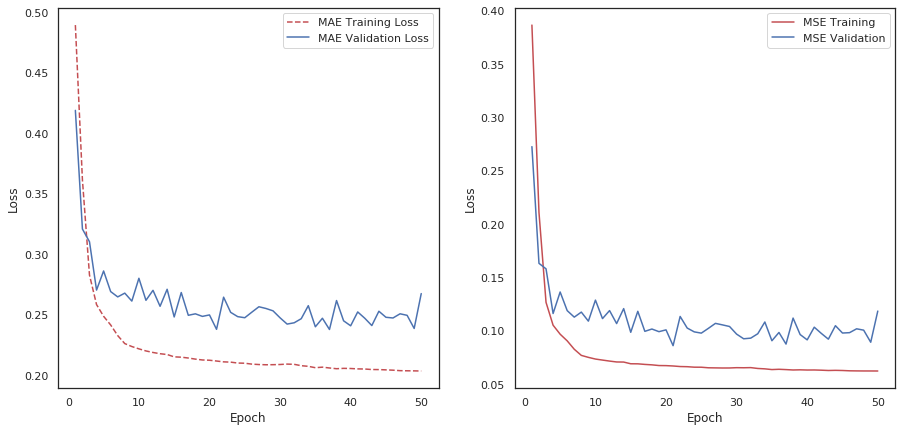

In [31]:
model, history = train_siamese(training_pairs=training_pairs, 
                               training_y=training_y, 
                               validation_pairs=validation_pairs, 
                               validation_y=validation_y,
              epochs=50,  #500
              batch_size=256,  #512 latest 
              learning_rate=0.001,  #0.01 
              plot=True,
              gpus=2)

In [32]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
mses = history.history['mse']
val_mses = history.history['val_mse']

np.savez("data/5j0n/5j0n_DE_history_full2", training_loss, val_loss, mses, val_mses)

In [36]:
data = np.load("data/5j0n/5j0n_DE_history_full2.npz")
training_loss, val_loss, mses, val_mses = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]

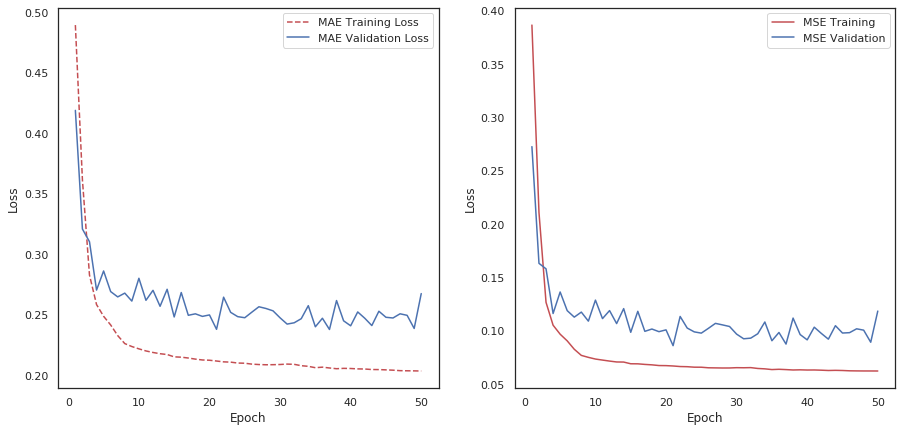

In [37]:
# Get training and test loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

In [39]:
# training_loss[50], val_loss[50], mses[50], val_mses[50]

### (Or) Read model checkpoint

In [40]:
# stop here, change file

In [16]:
# #model_filename = "training/20191218_023743.h5"

# On LTS: "training/20200221_061000.h5"
# model_filename = "training/20200220_055622.h5" local, MSE as loss, 60K training
#model_filename = "training/20200305_055207.h5" # local, MAE as loss, 60K training
#model_filename = "training/20200416_094914.h5"
#model_filename = "training/20200417_192953.h5"
#model_filename = "training/20200418_190002.h5"
#model_filename = "training/20200418_190118.h5" for symmetric
#model_filename = "training/20200422_114231.h5"
model_filename = "training/20200430_022437.h5"

In [17]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 116, 116, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 116, 116, 1)  0           input_3[0][0]                    
____________________________________________________________________________________________

### Some model results

In [47]:
# from cryoem.distance_estimation import plot_results

In [48]:
# y_tr_pred = model.predict_on_batch([tr_pairs[:256, 0], tr_pairs[:256, 1]])
# y_val_pred = model.predict_on_batch([val_pairs[:256, 0], val_pairs[:256, 1]])

In [49]:
# plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
# plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

In [50]:
# plot_train_results(1)

In [51]:
# plot_validation_results(0)

---

## dP/dQ plot

In [13]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [14]:
def d_p(p1, p2):
    dist = []
    p1 = tf.cast(p1, dtype=tf.float64)
    p2 = tf.cast(p2, dtype=tf.float64)

    for i in np.arange(0, len(p1), 256):
        _p1 = p1[i:i+256, :, :]
        _p2 = p2[i:i+256, :, :]
        
        _p1 = tf.convert_to_tensor(_p1)
        _p1 = tf.expand_dims(_p1, len(_p1.shape)) 
        _p2 = tf.convert_to_tensor(_p2)
        _p2 = tf.expand_dims(_p2, len(_p2.shape))   #p2 = p2.reshape(list(p2.shape) + [-1]) 

        d = model.predict_on_batch([_p1, _p2])
        d = tf.cast(d, dtype=tf.float64)
        dist.append(d)
    
    dist = tf.concat(dist, axis=0)

    return dist

In [18]:
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [59]:
np.savez("data/5j0n/5j0n_DE_dPdQ_plot_full2", dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

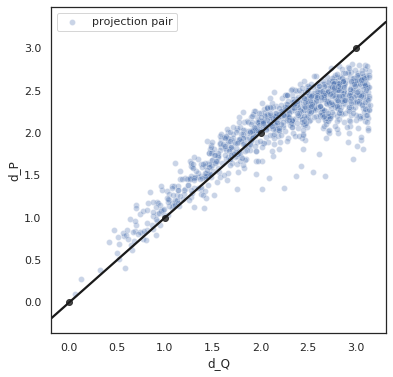

<Figure size 432x288 with 0 Axes>

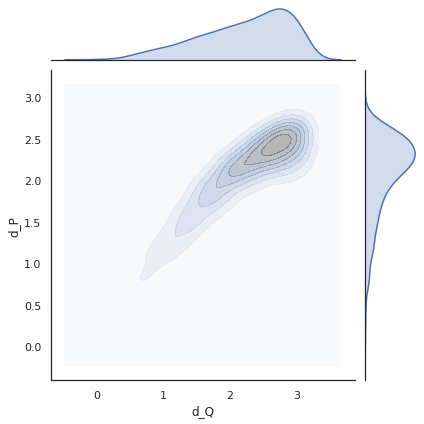

Variance = 0.3471605043872796
Min. angle recovery loss possible = 0.12039989539062391


In [19]:
plot_dP_dQ(dP_values, dQ_values)

# 2. Angle Recovery

## Angle Recovery

Perfect distances. Learning rate 0.01

In [42]:
from cryoem.angle_recovery import train_angle_recovery

In [43]:
X = tf.cast(X, dtype=tf.float64)
X = X.numpy()

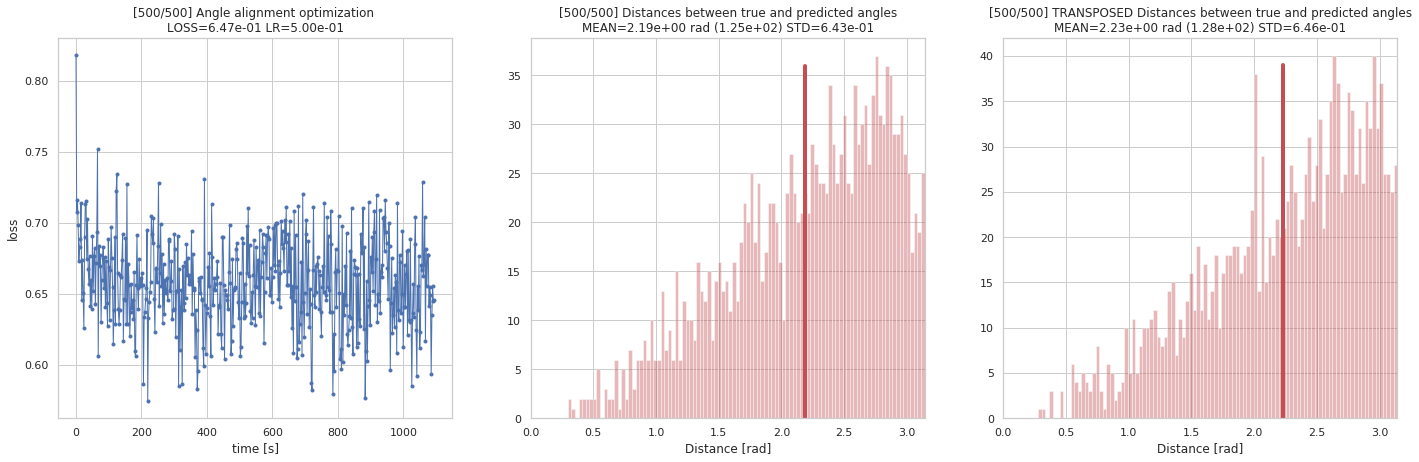

Shape of projections: (1650, 116, 116)step 50/500 (114s): loss = 6.97e-01
step 100/500 (221s): loss = 6.95e-01
step 150/500 (330s): loss = 6.69e-01
step 200/500 (439s): loss = 6.42e-01
step 250/500 (547s): loss = 6.56e-01
step 300/500 (656s): loss = 6.48e-01
step 350/500 (766s): loss = 6.45e-01
step 400/500 (875s): loss = 6.78e-01
step 450/500 (985s): loss = 6.39e-01
step 500/500 (1095s): loss = 6.45e-01



In [63]:
q_predicted, losses, q_all = train_angle_recovery(steps=500, 
                                                   batch_size=512, 
                                                   in_data=X[test_idx], 
                                                   distance_fn=d_p, 
                                                   learning_rate=0.5,
                                                   angles_true=y[test_idx],
                                                   optimization=True)

In [64]:
np.save("data/5j0n/predicted_quaternions_siamese_losses_full2.npy",     losses)
np.save("data/5j0n/predicted_quaternions_siamese_iterations_full2.npy", q_all)
np.save("data/5j0n/predicted_quaternions_siamese_full2.npy",            q_predicted.numpy())

##### Plots

In [20]:
losses      = np.load("data/5j0n/predicted_quaternions_siamese_losses_full2.npy")
q_all       = np.load("data/5j0n/predicted_quaternions_siamese_iterations_full2.npy")
q_predicted = np.load("data/5j0n/predicted_quaternions_siamese_full2.npy")

In [21]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

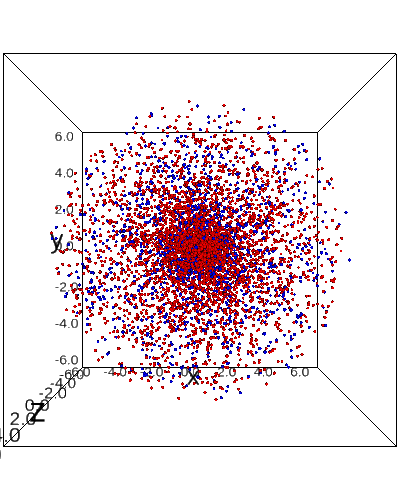

In [24]:
plot_iterations_polar_plot(q_all, angles_true, interval=100);

In [25]:
ipv.screenshot()

Output()

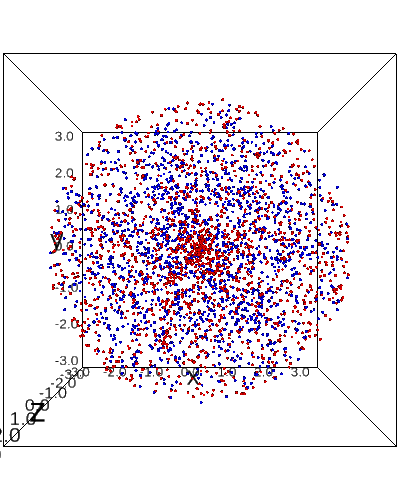

In [27]:
plot_iterations_rotvec(q_all, angles_true[test_idx], interval=100);

In [28]:
ipv.screenshot()

Output()

---

# Angle Alignment

#### Prediction angles from previous phase that we want to align with true angles

In [76]:
from cryoem.conversions import quaternion2euler

In [77]:
losses      = np.load("data/5j0n/predicted_quaternions_siamese_losses_full2.npy")
q_all       = np.load("data/5j0n/predicted_quaternions_siamese_iterations_full2.npy")
q_predicted = np.load("data/5j0n/predicted_quaternions_siamese_full2.npy")

In [78]:
angles_predicted = quaternion2euler(q_predicted).numpy()%(2*np.pi)

In [79]:
np.save("data/5j0n/predicted_angles_siamese_full2.npy", angles_predicted)

---

#### Run the Optimization

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

In [92]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion

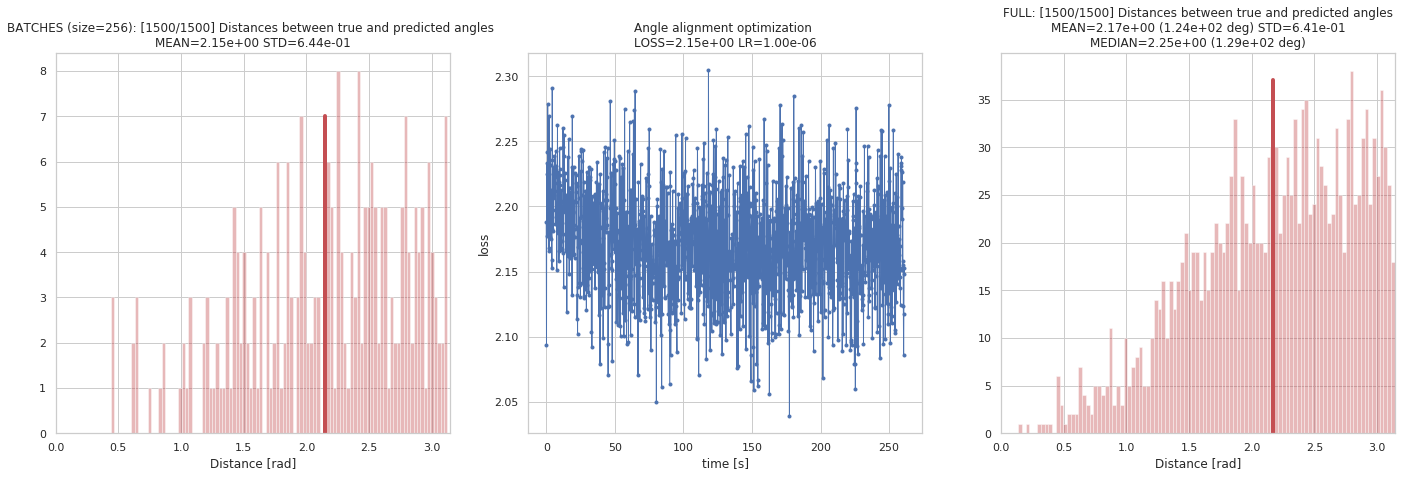

step 150/1500 (26s): loss = 2.20e+00
step 300/1500 (52s): loss = 2.18e+00
step 450/1500 (79s): loss = 2.17e+00
step 600/1500 (104s): loss = 2.16e+00
step 750/1500 (131s): loss = 2.17e+00
step 900/1500 (157s): loss = 2.17e+00
step 1050/1500 (183s): loss = 2.17e+00
step 1200/1500 (210s): loss = 2.17e+00
step 1350/1500 (237s): loss = 2.17e+00
step 1500/1500 (262s): loss = 2.17e+00

---


In [82]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=1500, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [83]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([4.79731217, 0.47183961, 4.23489485, 6.39060159, 4.50393441,
        3.83744466]),
 2.148301464719975)

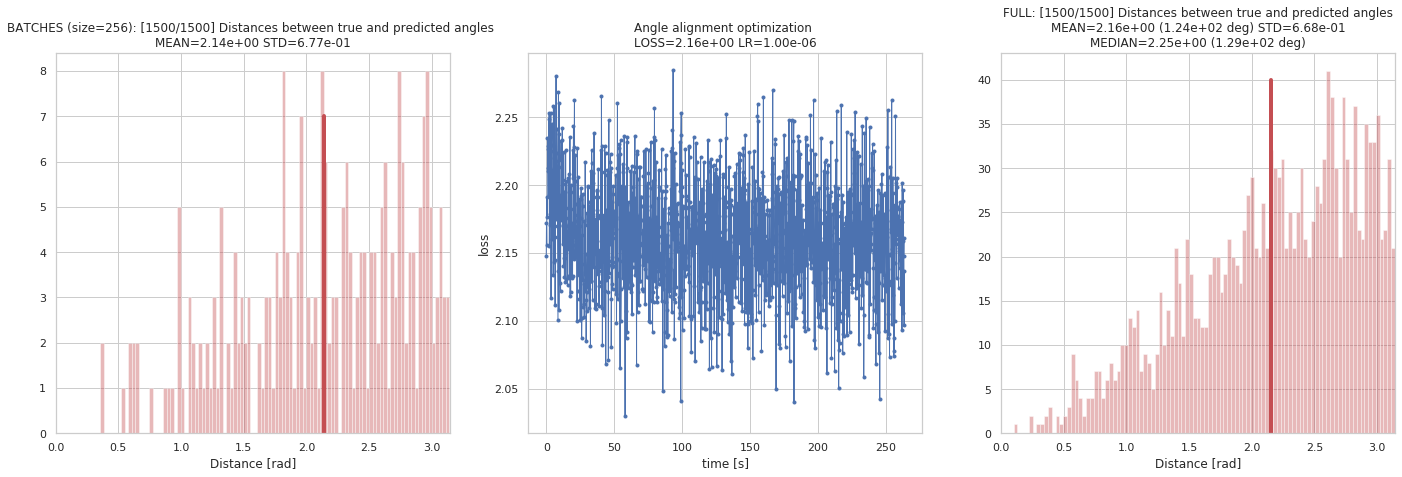

step 150/1500 (29s): loss = 2.18e+00
step 300/1500 (55s): loss = 2.16e+00
step 450/1500 (80s): loss = 2.16e+00
step 600/1500 (107s): loss = 2.16e+00
step 750/1500 (133s): loss = 2.16e+00
step 900/1500 (160s): loss = 2.16e+00
step 1050/1500 (186s): loss = 2.16e+00
step 1200/1500 (212s): loss = 2.16e+00
step 1350/1500 (239s): loss = 2.16e+00
step 1500/1500 (266s): loss = 2.16e+00

---


In [84]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[-1.0, 1.0, 1.0, 1.0],
                                                 steps=1500, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [85]:
m, rotation[0].numpy(), loss[-1]

([-1.0, 1.0, 1.0, 1.0],
 array([0.93622005, 5.7981578 , 2.49340062, 4.59311326, 1.88840009,
        3.36816964]),
 2.1371103143034773)

##### Plots

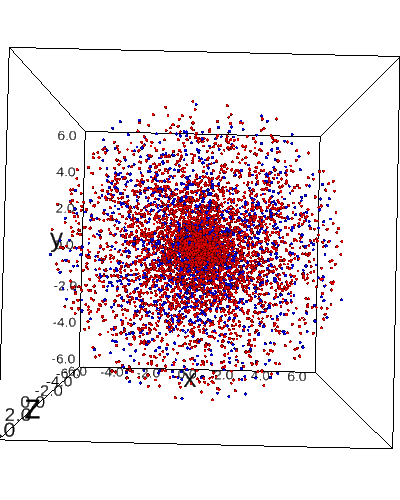

In [86]:
plot_iterations_polar_plot(collect_data, angles_true);

In [87]:
ipv.screenshot()

Output()

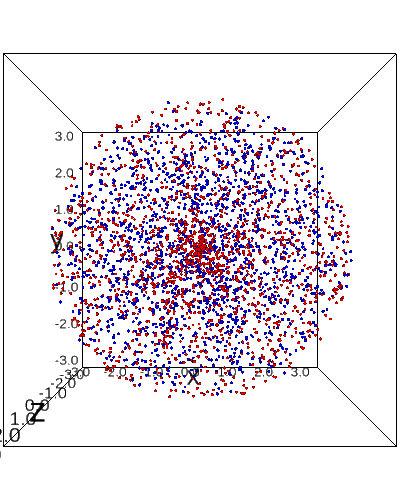

In [89]:
plot_iterations_rotvec(collect_data, angles_true[test_idx]);

In [90]:
ipv.screenshot()

Output()

In [93]:
qpn = euler2quaternion(angles_predicted)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted_rotated = quaternion2euler(qpa).numpy()

np.save("data/5j0n/predicted_angles_siamese_updated_full2.npy", angles_predicted_rotated)

In [51]:
# Image(filename='../3-reconstruction/data/5j0n_projections_and_angles_predicted_updated.png')